# Detecting cell centers using method of Hirose et al., 2018

In [1]:
%matplotlib inline

In [2]:
import h5py
import dpmeans
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from skimage.feature import peak_local_max
from skimage.util import img_as_float
from skimage.measure import label
from scipy import ndimage

### Load Zimmer data

In [3]:
# Path to HDF5 file
in_fpath = '/home/mn2822/Desktop/WormTracking/data/zimmer/mCherry_v00065-01581.hdf5'

# Index of frame to use
t_frame = 500

with h5py.File(in_fpath, 'r') as f:
    dset = f.get('mCherry')
    frame = dset[t_frame, 0, :, :, :]
    frame = np.moveaxis(frame, [0, 1, 2], [2, 1, 0])

### Select section of frame for test image

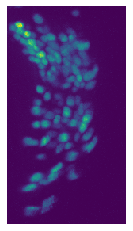

In [4]:
# Section of XY plane where head is found
head_x = (500, 650)
head_y = (250, 525)
head_z = (0, 33)

# Extract section
img = frame[head_x[0]:head_x[1], head_y[0]:head_y[1], head_z[0]:head_z[1]]
img = img_as_float(img)

# Compute image min and max
img_min = np.min(img)
img_max = np.max(img)

# Display max projection
plt.imshow(np.max(img, 2).T);
plt.axis('off');

### Apply Laplacian of Gaussian (LoG) filter

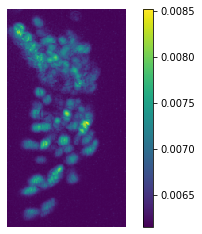

In [5]:
sigma_filter = 1.0

# Apply LoG filter
img_lg = ndimage.gaussian_laplace(img, sigma_filter)

# Shift pixel values to make them positive
img_sc = img_lg - np.min(img_lg)

plt.imshow(np.max(img_sc, 2).T);
plt.axis('off');
plt.colorbar();

### Apply threshold to image

In [6]:
threshold_rel = 0.2

# Apply threshold 
threshold_abs = img_min + threshold_rel * (img_max - img_min)
idx_below_th = img < threshold_abs
img_th = np.copy(img)
img_th[idx_below_th] = 0.0

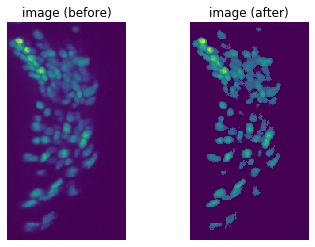

In [7]:
fig = plt.figure()

plt.subplot(121)
plt.imshow(np.max(img, 2).T);
plt.title('image (before)')
plt.axis('off')

plt.subplot(122)
plt.imshow(np.max(img_th, 2).T);
plt.title('image (after)')
plt.axis('off');

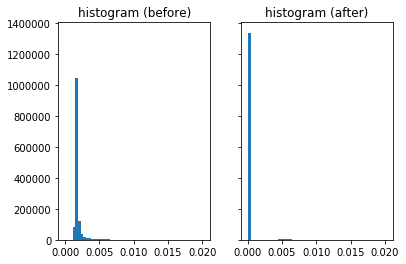

In [8]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)

axs[0].hist(img.flatten(), 50)
axs[0].set_title('histogram (before)')

axs[1].hist(img_th.flatten(), 50);
axs[1].set_title('histogram (after)');

### Find local peaks

In [9]:
peaks = peak_local_max(img_th, min_distance=2)

#### Plot slices of original image with identified local peaks

In [10]:
def plot_slice_cells(img, cells, z_min, width, ax, vmin=None, vmax=None):
    
    if vmin is None:
        vmin = np.min(img)
    if vmax is None:
        vmax = np.max(img)
    
    z_max = min(z_min + width, img.shape[2])

    img_sl = img[:, :, z_min:z_max]
    cells_sl_idx = (cells[:, 2] >= z_min) & (cells[:, 2] < z_max)
    cells_sl = cells[cells_sl_idx]
    
    ax.imshow(np.max(img_sl, 2).T, vmin=vmin, vmax=vmax);
    ax.scatter(cells_sl[:, 0], cells_sl[:, 1], marker='*', color='r')
    ax.axis('off');
    ax.set_title(f'z: {z_min}-{z_max}')

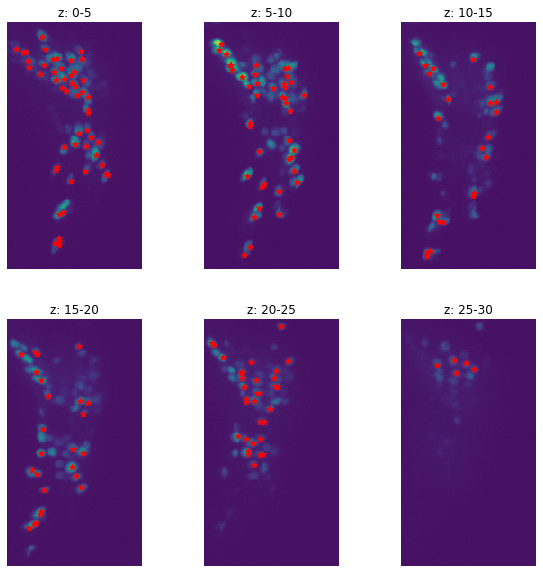

In [11]:
fig, axs = plt.subplots(
    2, 3, 
    sharex=True, sharey=True, 
    figsize=(10, 10)
)

for s in range(0, 6):
    
    z_min = 5 * s
    width = 5
    ax = axs.flatten()[s]
    
    plot_slice_cells(img, peaks, z_min, width, ax, vmin=img_min, vmax=img_max)

#### Widget

In [12]:
z_min_widget = widgets.IntSlider(min=0, max=img.shape[2] - 1, step=1, value=0)
width_widget = widgets.IntSlider(min=1, max=img.shape[2], step=1, value=1)

@widgets.interact(z_min=z_min_widget, width=width_widget)
def slice_peak_widget(z_min, width):
    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plot_slice_cells(img, peaks, z_min, width, ax, vmin=img_min, vmax=img_max)

interactive(children=(IntSlider(value=0, description='z_min', max=32), IntSlider(value=1, description='width',…

### TODO: Cluster local peaks using DP-Means algorithm